In [14]:
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time




In [2]:
!pip install transformers sentencepiece topsis


  Preparing metadata (setup.py) ... done
  Created wheel for topsis: filename=topsis-0.2-py3-none-any.whl size=2159 sha256=a50256b9d0513dd6ba836f8dc41866d57d2db9271cab3c9fdcfad456d9b0f2c0
  Stored in directory: /root/.cache/pip/wheels/e6/1b/17/94ab15cc12c0cbefd77bca994198571cdc27cf52e0471c93cc
Successfully built topsis


In [7]:
models = {
    "DialoGPT-small": pipeline(
        "text-generation",
        model="microsoft/DialoGPT-small",
        truncation=True,
        pad_token_id=50256
    ),
    "DialoGPT-medium": pipeline(
        "text-generation",
        model="microsoft/DialoGPT-medium",
        truncation=True,
        pad_token_id=50256
    ),
    "BlenderBot": pipeline(
        "text2text-generation",
        model="facebook/blenderbot-400M-distill",
        truncation=True
    ),
    "Flan-T5-small": pipeline(
        "text2text-generation",
        model="google/flan-t5-small",
        truncation=True
    ),
    "Flan-T5-base": pipeline(
        "text2text-generation",
        model="google/flan-t5-base",
        truncation=True
    )
}



Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


In [5]:
prompts = [
    "Explain artificial intelligence in simple words.",
    "Why is data security important?",
    "What is machine learning?",
    "How does AI help in healthcare?",
    "Explain cloud computing briefly."
]


In [15]:
results = {}

for model_name, model in models.items():
    lengths = []
    vocab_ratios = []
    repetition_rates = []
    times = []

    for prompt in prompts:
        start = time.time()
        output = model(prompt, max_new_tokens=60, do_sample=False)[0]["generated_text"]
        elapsed = time.time() - start

        words = output.split()
        total_words = len(words)
        unique_words = len(set(words))

        lengths.append(total_words)
        vocab_ratios.append(unique_words / total_words if total_words > 0 else 0)
        repetition_rates.append(1 - (unique_words / total_words) if total_words > 0 else 0)
        times.append(elapsed)

    results[model_name] = [
        np.mean(lengths),          # Avg Length (↑)
        np.max(lengths),           # Max Length (↑)
        np.mean(vocab_ratios),     # Vocabulary Richness (↑)
        np.mean(repetition_rates), # Repetition Rate (↓)
        np.mean(times)             # Response Time (↓)
    ]


In [16]:
df = pd.DataFrame(
    results,
    index=[
        "Avg_Length",
        "Max_Length",
        "Vocab_Richness",
        "Repetition_Rate",
        "Response_Time"
    ]
).T

print("Decision Matrix:")
df


Decision Matrix:


,Avg_Length,Max_Length,Vocab_Richness,Repetition_Rate,Response_Time
DialoGPT-small,8.2,18.0,0.952778,0.047222,3.931138
DialoGPT-medium,6.6,9.0,0.955556,0.044444,17.554560
BlenderBot,18.8,24.0,0.873214,0.126786,10.919835
Flan-T5-small,19.0,48.0,0.697619,0.302381,2.260624
Flan-T5-base,16.4,51.0,0.809902,0.190098,5.018894


In [17]:
decision_matrix = df.values

weights = np.array([0.25, 0.20, 0.20, 0.15, 0.20])
criteria = np.array([1, 1, 1, -1, -1])  # Benefit / Cost



In [18]:
def topsis(decision_matrix, weights, criteria):
    norm = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))
    weighted = norm * weights

    ideal = np.max(weighted * criteria, axis=0)
    anti_ideal = np.min(weighted * criteria, axis=0)

    d_pos = np.sqrt(((weighted - ideal) ** 2).sum(axis=1))
    d_neg = np.sqrt(((weighted - anti_ideal) ** 2).sum(axis=1))

    score = d_neg / (d_pos + d_neg)
    rank = score.argsort()[::-1] + 1
    return score, rank


In [19]:
scores, ranks = topsis(decision_matrix, weights, criteria)

df["TOPSIS Score"] = scores
df["Rank"] = ranks
df = df.sort_values("Rank")

print(df)


                 Avg_Length  Max_Length  Vocab_Richness  Repetition_Rate  \
Flan-T5-small          19.0        48.0        0.697619         0.302381   
Flan-T5-base           16.4        51.0        0.809902         0.190098   
BlenderBot             18.8        24.0        0.873214         0.126786   
DialoGPT-medium         6.6         9.0        0.955556         0.044444   
DialoGPT-small          8.2        18.0        0.952778         0.047222   

                 Response_Time  TOPSIS Score  Rank  
Flan-T5-small         2.260624      0.694923     1  
Flan-T5-base          5.018894      0.729160     2  
BlenderBot           10.919835      0.677738     3  
DialoGPT-medium      17.554560      0.599128     4  
DialoGPT-small        3.931138      0.640568     5  


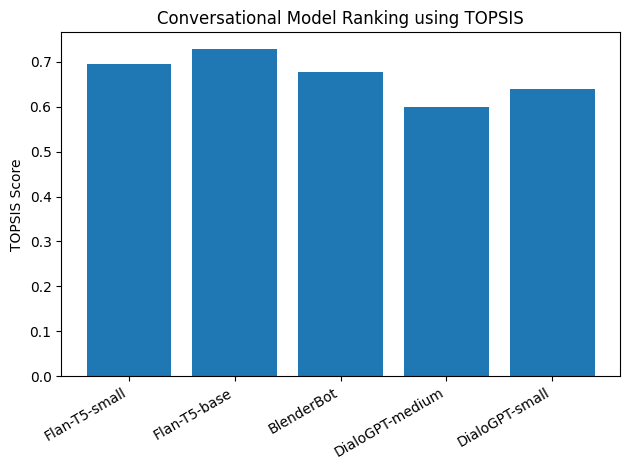

In [20]:
plt.figure()
plt.bar(df.index, df["TOPSIS Score"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("TOPSIS Score")
plt.title("Conversational Model Ranking using TOPSIS")
plt.tight_layout()
plt.show()
